# Predictive Modelling

## Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from adjustText import adjust_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore") # <--- comment out this line if running for the first time
random_state = 9

## Load Data and Conduct Necessary Checks

In [2]:
df_review_norm = pd.read_csv('review_camera_normalised.csv')
df_review_norm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502223 entries, 0 to 2502222
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   overall     float64
 1   verified    bool   
 2   reviewTime  object 
 3   asin        object 
 4   reviewText  object 
 5   vote        object 
 6   image       bool   
 7   Year        int64  
 8   price       float64
 9   main_cat    object 
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 157.5+ MB


In [3]:
df_review_norm.dropna(subset=['reviewText'], inplace=True)
df_review_norm["reviewText"].isna().sum()

0

In [4]:
# Due to computational constraints, we will use a subset of the data for modelling
# However, balancing computational power and accuracy, the subset is still in decent size which represents common review text and the distribution of the entire dataset

df_review_subset = df_review_norm.sample(frac=0.2, random_state=random_state)
df_review_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 498219 entries, 1749421 to 619313
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     498219 non-null  float64
 1   verified    498219 non-null  bool   
 2   reviewTime  498219 non-null  object 
 3   asin        498219 non-null  object 
 4   reviewText  498219 non-null  object 
 5   vote        91312 non-null   object 
 6   image       498219 non-null  bool   
 7   Year        498219 non-null  int64  
 8   price       321922 non-null  float64
 9   main_cat    498219 non-null  object 
dtypes: bool(2), float64(2), int64(1), object(5)
memory usage: 35.2+ MB


## Define Useful Functions and Variables

In [5]:
# define function to transform continuous predictions into discrete rating classes
def round_and_clip_predictions(predictions):
    rounded_predictions = np.round(predictions)
    clipped_predictions = np.clip(rounded_predictions, 1, 5)
    return clipped_predictions

In [6]:
# define search space and some hyperparameters
# Vectorizer
max_features= 3500

In [7]:
# define search space and some hyperparameters
# LASSO
alphas_search_space = [0.0001, 0.001, 0.01, 0.1, 1]
max_iter= 2000
n_jobs= -1
cv= 3

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df_review_subset["reviewText"], df_review_subset["overall"], test_size=0.25, random_state=random_state)

## N-gram LASSO

### Ngram = 1

#### CountVectorizer Ngram = 1

In [9]:
# Lasso CV
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter=max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['countvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_cove_1_1 = pipeline.predict(X_test)
mse_lasso_cove_1_1 = mean_squared_error(y_test, y_pred_lasso_cove_1_1)
acc_lasso_cove_1_1 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_cove_1_1))

print(f'Mean Squared Error: {mse_lasso_cove_1_1}')
print(f'Classification Accuracy: {acc_lasso_cove_1_1}')
best_alpha_ngram_1_CoVe = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_CoVe}')

Mean Squared Error: 1.10804452776428
Classification Accuracy: 0.3708241339167436
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [10]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_CoVe_1_1, sorted_coefficients_lasso_CoVe_1_1 = zip(*sorted_features_coefficients)

top_pos_features_lasso_CoVe_1_1 = []
top_pos_coef_lasso_CoVe_1_1 = []
top_pos_features_feq_lasso_CoVe_1_1 = []

top_neg_features_lasso_CoVe_1_1 = []
top_neg_coef_lasso_CoVe_1_1 = []
top_neg_features_feq_lasso_CoVe_1_1 = []

for index, coef in enumerate(sorted_coefficients_lasso_CoVe_1_1):
    if coef > 0:
        top_pos_features_lasso_CoVe_1_1.append(sorted_features_lasso_CoVe_1_1[index])
        top_pos_features_feq_lasso_CoVe_1_1.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_1[index]]))
        top_pos_coef_lasso_CoVe_1_1.append(coef)
    else:
        top_neg_features_lasso_CoVe_1_1.append(sorted_features_lasso_CoVe_1_1[index])
        top_neg_features_feq_lasso_CoVe_1_1.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_1[index]]))
        top_neg_coef_lasso_CoVe_1_1.append(coef)

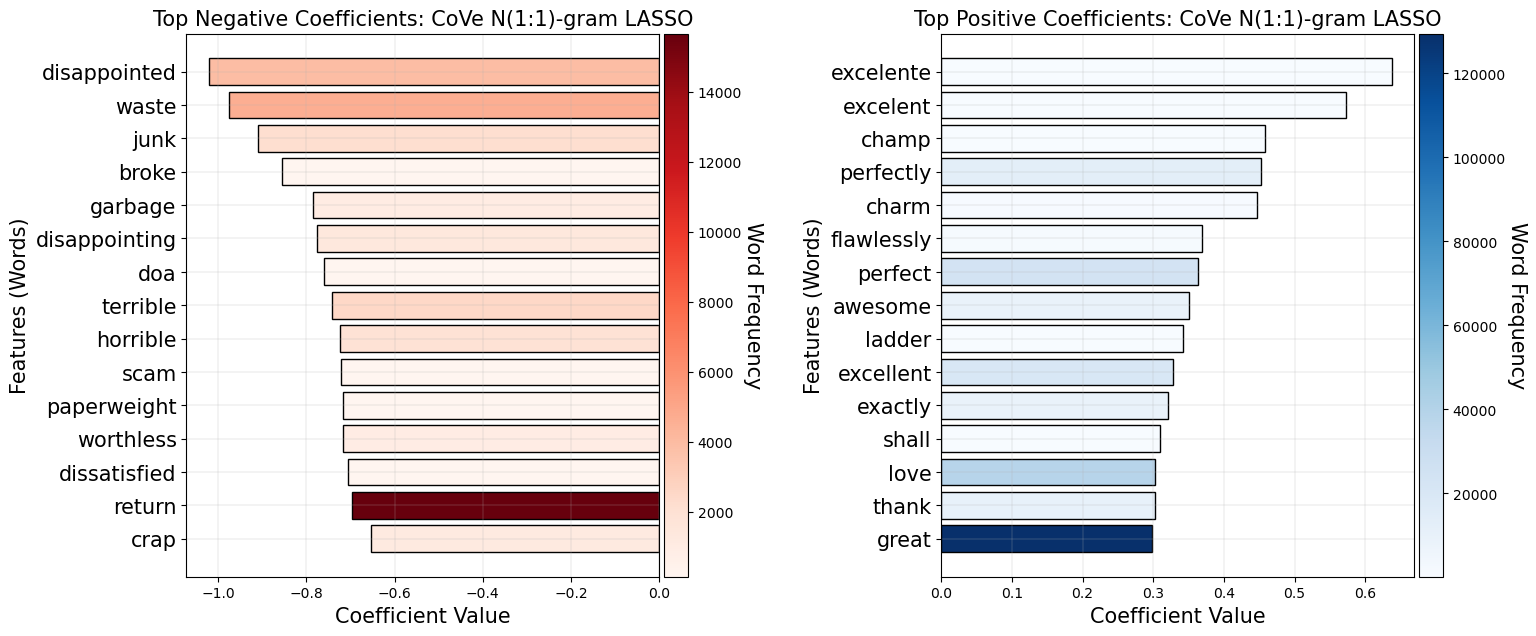

In [11]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_CoVe_1_1[:show]), 
                             vmax=max(top_neg_features_feq_lasso_CoVe_1_1[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_CoVe_1_1[:show]), 
                             vmax=max(top_pos_features_feq_lasso_CoVe_1_1[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_CoVe_1_1[i]))
    ax1.barh(top_neg_features_lasso_CoVe_1_1[i], top_neg_coef_lasso_CoVe_1_1[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: CoVe N(1:1)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_CoVe_1_1[i]))
    ax2.barh(top_pos_features_lasso_CoVe_1_1[i], top_pos_coef_lasso_CoVe_1_1[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: CoVe N(1:1)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


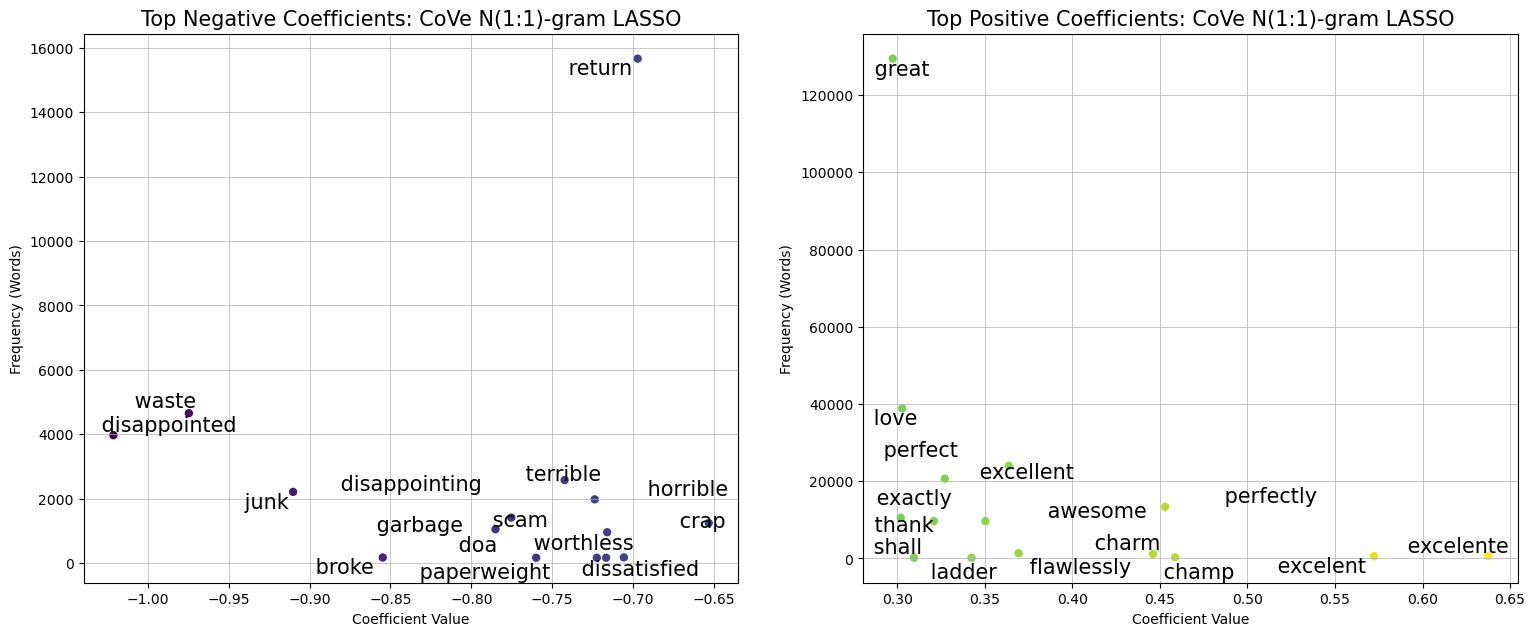

In [12]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_CoVe_1_1[:show]), 
                                  min(top_pos_coef_lasso_CoVe_1_1[:show])), 
                         vmax=max(max(top_neg_coef_lasso_CoVe_1_1[:show]), 
                                  max(top_pos_coef_lasso_CoVe_1_1[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_CoVe_1_1[:show], top_neg_features_feq_lasso_CoVe_1_1[:show],
                      c=top_neg_coef_lasso_CoVe_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: CoVe N(1:1)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_CoVe_1_1[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_CoVe_1_1[i], top_neg_features_feq_lasso_CoVe_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_CoVe_1_1[:show], top_pos_features_feq_lasso_CoVe_1_1[:show],
                      c=top_pos_coef_lasso_CoVe_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: CoVe N(1:1)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_CoVe_1_1[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_CoVe_1_1[i], top_pos_features_feq_lasso_CoVe_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


#### TfidfVectorizer Ngram = 1

In [13]:
# Lasso CV 
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,1), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter= max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['tfidfvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_tfidf_1_1 = pipeline.predict(X_test)
mse_lasso_tfidf_1_1 = mean_squared_error(y_test, y_pred_lasso_tfidf_1_1)
acc_lasso_tfidf_1_1 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_tfidf_1_1))

print(f'Mean Squared Error: {mse_lasso_tfidf_1_1}')
print(f'Classification Accuracy : {acc_lasso_tfidf_1_1}')
best_alpha_ngram_1_tfidf = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_tfidf}')

Mean Squared Error: 0.9083344913133121
Classification Accuracy : 0.4669664003853719
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [14]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_tfidf_1_1, sorted_coefficients_lasso_tfidf_1_1 = zip(*sorted_features_coefficients)

top_pos_features_lasso_tfidf_1_1 = []
top_pos_coef_lasso_tfidf_1_1 = []
top_pos_features_feq_lasso_tfidf_1_1 = []

top_neg_features_lasso_tfidf_1_1 = []
top_neg_coef_lasso_tfidf_1_1 = []
top_neg_features_feq_lasso_tfidf_1_1 = []

for index, coef in enumerate(sorted_coefficients_lasso_tfidf_1_1):
    if coef > 0:
        top_pos_features_lasso_tfidf_1_1.append(sorted_features_lasso_tfidf_1_1[index])
        top_pos_features_feq_lasso_tfidf_1_1.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_1[index]]))
        top_pos_coef_lasso_tfidf_1_1.append(coef)
    else:
        top_neg_features_lasso_tfidf_1_1.append(sorted_features_lasso_tfidf_1_1[index])
        top_neg_features_feq_lasso_tfidf_1_1.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_1[index]]))
        top_neg_coef_lasso_tfidf_1_1.append(coef)

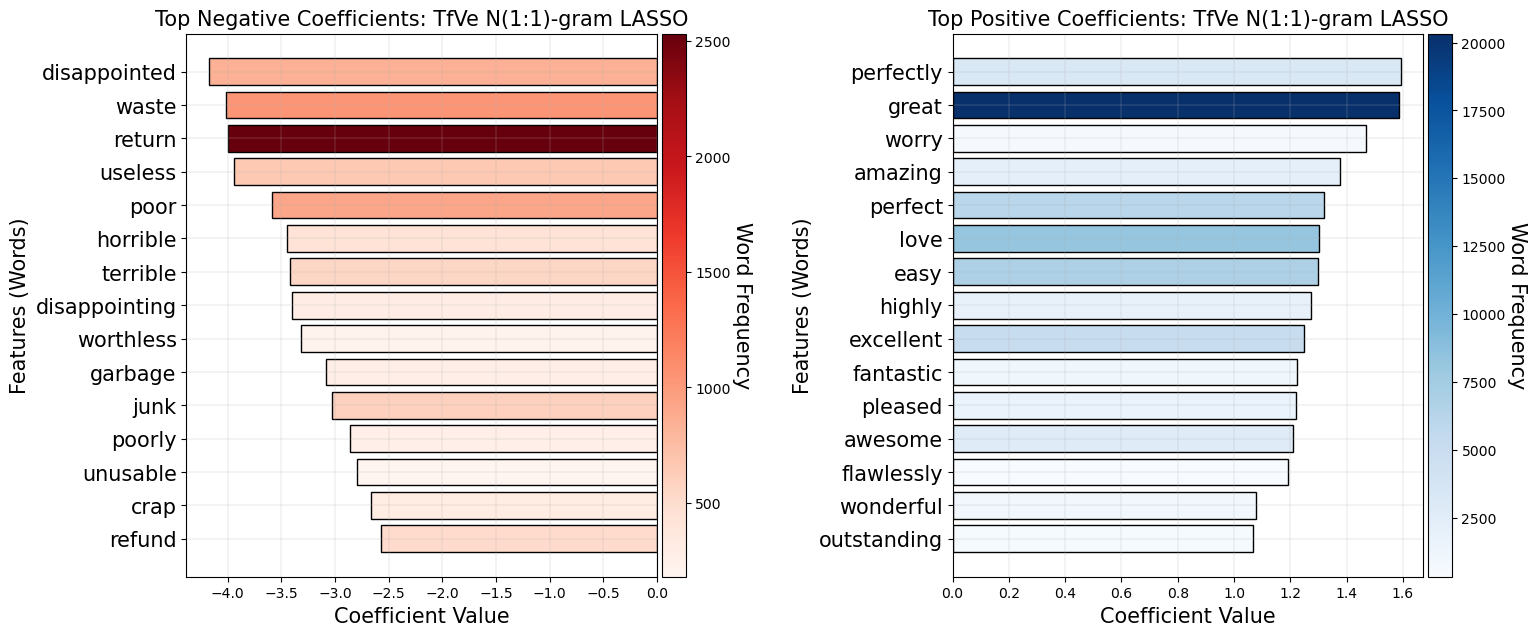

In [15]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_tfidf_1_1[:show]), 
                             vmax=max(top_neg_features_feq_lasso_tfidf_1_1[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_tfidf_1_1[:show]), 
                             vmax=max(top_pos_features_feq_lasso_tfidf_1_1[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_tfidf_1_1[i]))
    ax1.barh(top_neg_features_lasso_tfidf_1_1[i], top_neg_coef_lasso_tfidf_1_1[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: TfVe N(1:1)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_tfidf_1_1[i]))
    ax2.barh(top_pos_features_lasso_tfidf_1_1[i], top_pos_coef_lasso_tfidf_1_1[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: TfVe N(1:1)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


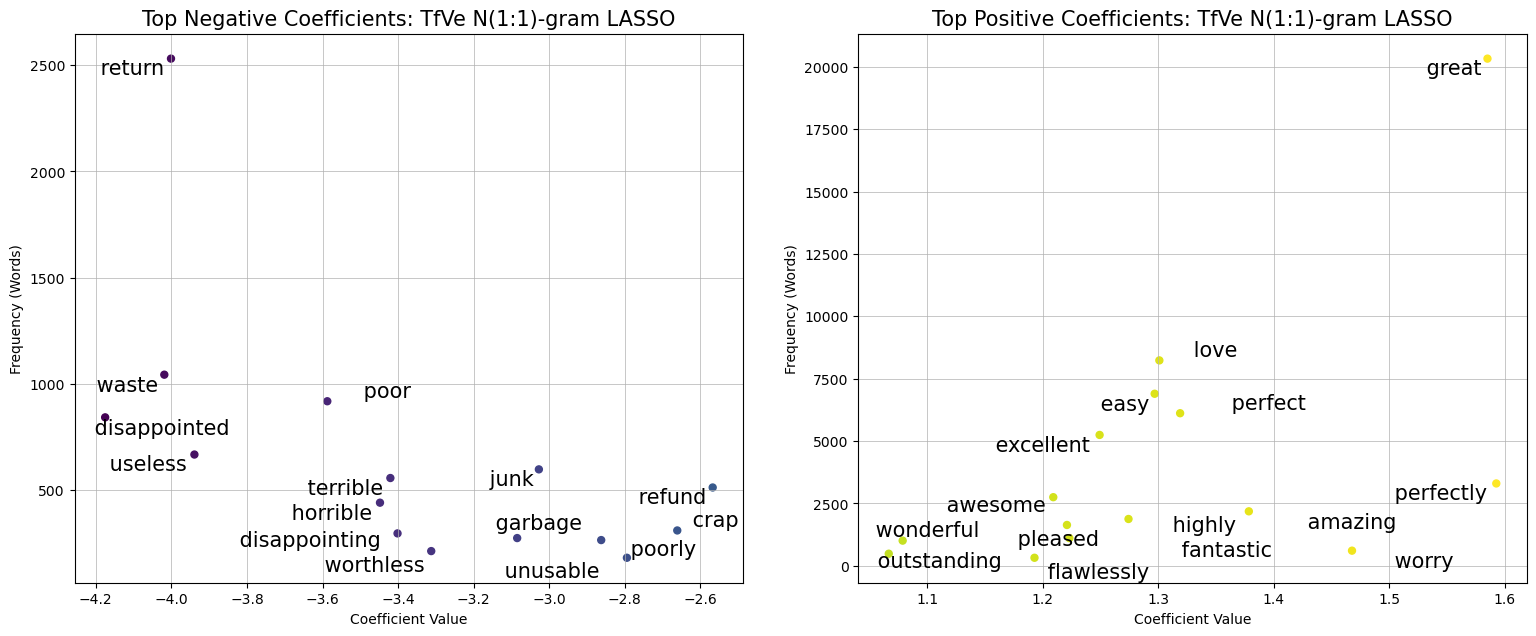

In [16]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_tfidf_1_1[:show]), 
                                  min(top_pos_coef_lasso_tfidf_1_1[:show])), 
                         vmax=max(max(top_neg_coef_lasso_tfidf_1_1[:show]), 
                                  max(top_pos_coef_lasso_tfidf_1_1[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_tfidf_1_1[:show], top_neg_features_feq_lasso_tfidf_1_1[:show],
                      c=top_neg_coef_lasso_tfidf_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: TfVe N(1:1)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_tfidf_1_1[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_tfidf_1_1[i], top_neg_features_feq_lasso_tfidf_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_tfidf_1_1[:show], top_pos_features_feq_lasso_tfidf_1_1[:show],
                      c=top_pos_coef_lasso_tfidf_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: TfVe N(1:1)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_tfidf_1_1[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_tfidf_1_1[i], top_pos_features_feq_lasso_tfidf_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


### Ngram = 1:2

#### CountVectorizer Ngram = 1:2

In [17]:
# Lasso CV
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,2), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter=max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['countvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_cove_1_2 = pipeline.predict(X_test)
mse_lasso_cove_1_2 = mean_squared_error(y_test, y_pred_lasso_cove_1_2)
acc_lasso_cove_1_2 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_cove_1_2))

print(f'Mean Squared Error: {mse_lasso_cove_1_2}')
print(f'Classification Accuracy: {acc_lasso_cove_1_2}')
best_alpha_ngram_1_2_CoVe = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_2_CoVe}')

Mean Squared Error: 1.0778439257114345
Classification Accuracy: 0.3897876440126852
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [18]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_CoVe_1_2, sorted_coefficients_lasso_CoVe_1_2 = zip(*sorted_features_coefficients)

top_pos_features_lasso_CoVe_1_2 = []
top_pos_coef_lasso_CoVe_1_2 = []
top_pos_features_feq_lasso_CoVe_1_2 = []

top_neg_features_lasso_CoVe_1_2 = []
top_neg_coef_lasso_CoVe_1_2 = []
top_neg_features_feq_lasso_CoVe_1_2 = []

for index, coef in enumerate(sorted_coefficients_lasso_CoVe_1_2):
    if coef > 0:
        top_pos_features_lasso_CoVe_1_2.append(sorted_features_lasso_CoVe_1_2[index])
        top_pos_features_feq_lasso_CoVe_1_2.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_2[index]]))
        top_pos_coef_lasso_CoVe_1_2.append(coef)
    else:
        top_neg_features_lasso_CoVe_1_2.append(sorted_features_lasso_CoVe_1_2[index])
        top_neg_features_feq_lasso_CoVe_1_2.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_2[index]]))
        top_neg_coef_lasso_CoVe_1_2.append(coef)

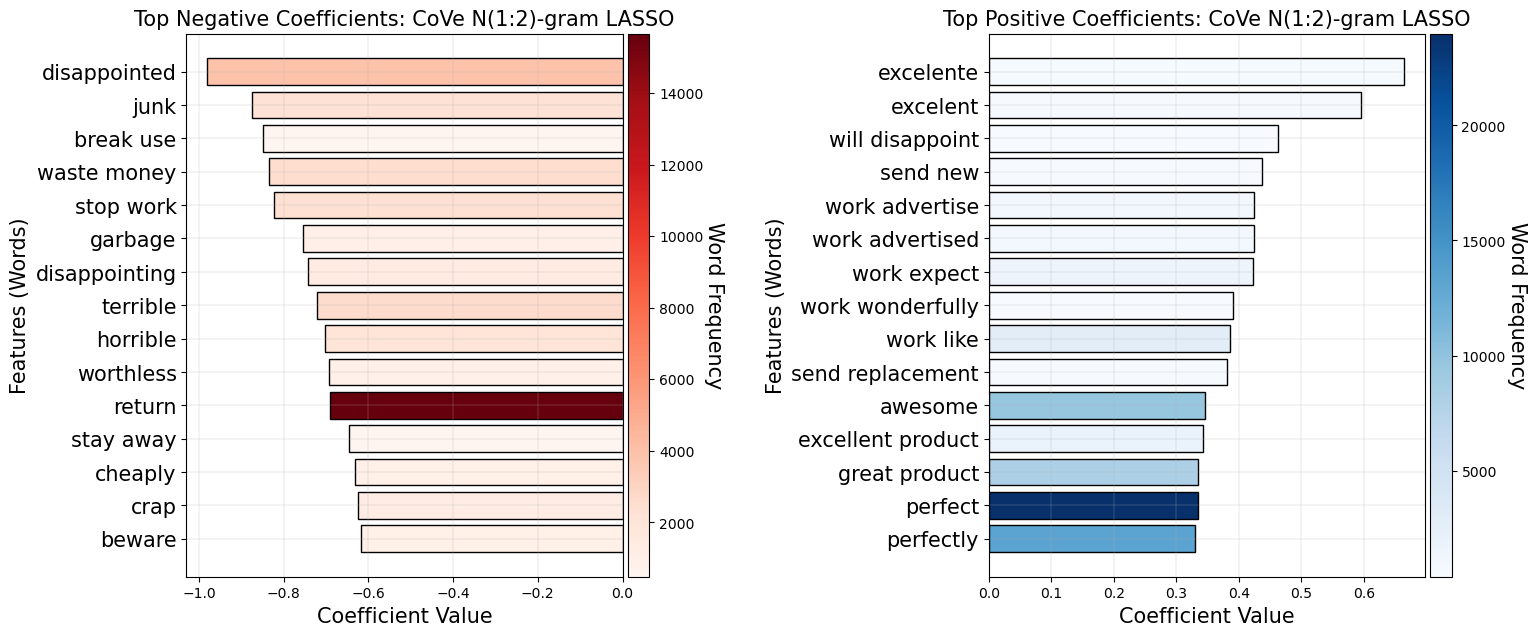

In [19]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_CoVe_1_2[:show]), 
                             vmax=max(top_neg_features_feq_lasso_CoVe_1_2[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_CoVe_1_2[:show]), 
                             vmax=max(top_pos_features_feq_lasso_CoVe_1_2[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_CoVe_1_2[i]))
    ax1.barh(top_neg_features_lasso_CoVe_1_2[i], top_neg_coef_lasso_CoVe_1_2[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: CoVe N(1:2)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_CoVe_1_2[i]))
    ax2.barh(top_pos_features_lasso_CoVe_1_2[i], top_pos_coef_lasso_CoVe_1_2[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: CoVe N(1:2)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


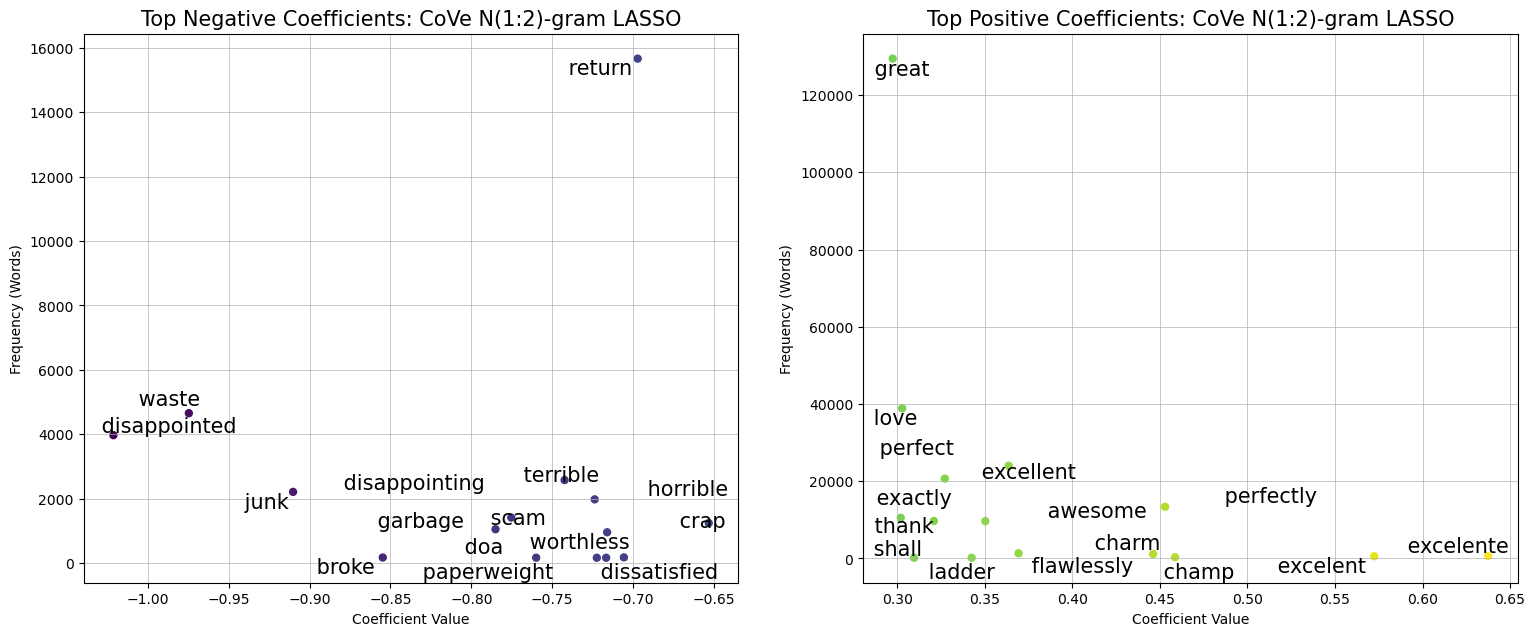

In [20]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_CoVe_1_1[:show]), 
                                  min(top_pos_coef_lasso_CoVe_1_1[:show])), 
                         vmax=max(max(top_neg_coef_lasso_CoVe_1_1[:show]), 
                                  max(top_pos_coef_lasso_CoVe_1_1[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_CoVe_1_1[:show], top_neg_features_feq_lasso_CoVe_1_1[:show],
                      c=top_neg_coef_lasso_CoVe_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: CoVe N(1:2)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_CoVe_1_1[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_CoVe_1_1[i], top_neg_features_feq_lasso_CoVe_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_CoVe_1_1[:show], top_pos_features_feq_lasso_CoVe_1_1[:show],
                      c=top_pos_coef_lasso_CoVe_1_1[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: CoVe N(1:2)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_CoVe_1_1[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_CoVe_1_1[i], top_pos_features_feq_lasso_CoVe_1_1[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


#### TfidfVectorizer Ngram = 1:2

In [21]:
# Lasso CV 
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,2), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter= max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['tfidfvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_tfidf_1_2 = pipeline.predict(X_test)
mse_lasso_tfidf_1_2 = mean_squared_error(y_test, y_pred_lasso_tfidf_1_2)
acc_lasso_tfidf_1_2 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_tfidf_1_2))

print(f'Mean Squared Error: {mse_lasso_tfidf_1_2}')
print(f'Classification Accuracy : {acc_lasso_tfidf_1_2}')
best_alpha_ngram_1_2_tfidf = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_2_tfidf}')

Mean Squared Error: 0.8889506757590614
Classification Accuracy : 0.47765244269599777
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [22]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_tfidf_1_2, sorted_coefficients_lasso_tfidf_1_2 = zip(*sorted_features_coefficients)

top_pos_features_lasso_tfidf_1_2 = []
top_pos_coef_lasso_tfidf_1_2 = []
top_pos_features_feq_lasso_tfidf_1_2 = []

top_neg_features_lasso_tfidf_1_2 = []
top_neg_coef_lasso_tfidf_1_2 = []
top_neg_features_feq_lasso_tfidf_1_2 = []

for index, coef in enumerate(sorted_coefficients_lasso_tfidf_1_2):
    if coef > 0:
        top_pos_features_lasso_tfidf_1_2.append(sorted_features_lasso_tfidf_1_2[index])
        top_pos_features_feq_lasso_tfidf_1_2.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_2[index]]))
        top_pos_coef_lasso_tfidf_1_2.append(coef)
    else:
        top_neg_features_lasso_tfidf_1_2.append(sorted_features_lasso_tfidf_1_2[index])
        top_neg_features_feq_lasso_tfidf_1_2.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_2[index]]))
        top_neg_coef_lasso_tfidf_1_2.append(coef)

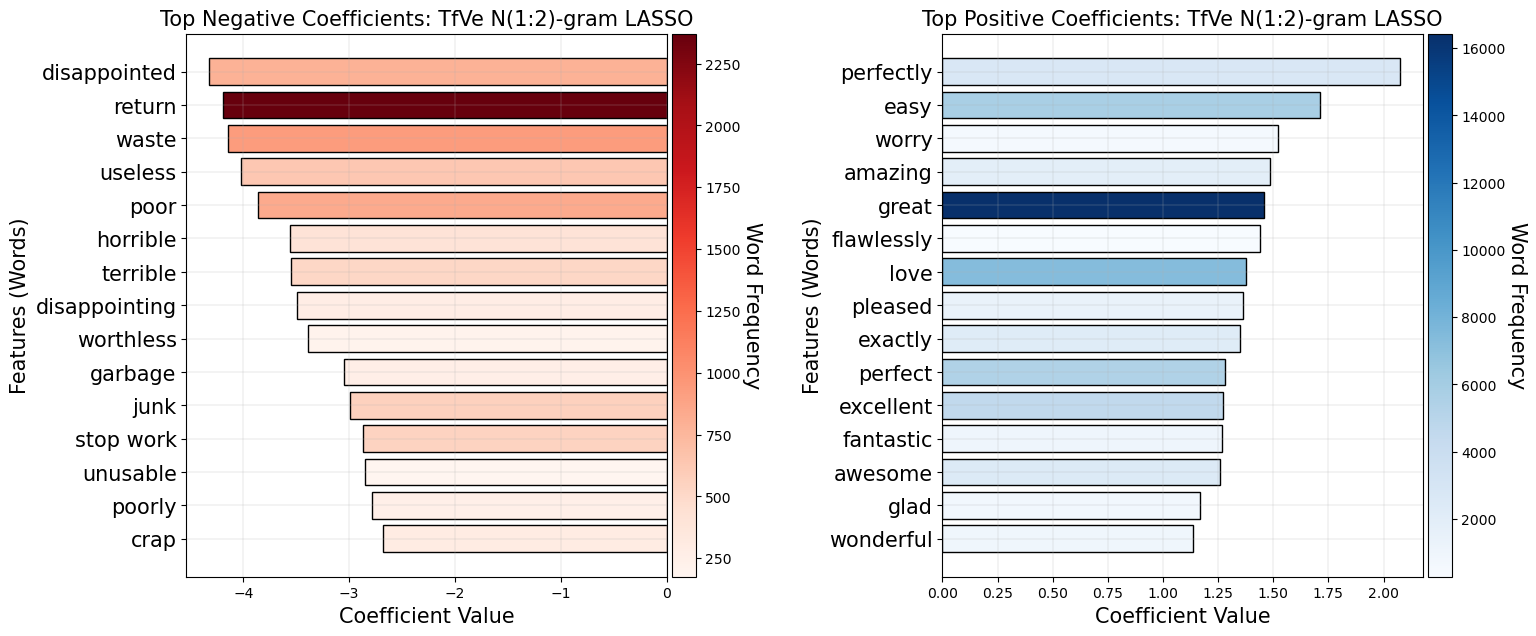

In [23]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_tfidf_1_2[:show]), 
                             vmax=max(top_neg_features_feq_lasso_tfidf_1_2[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_tfidf_1_2[:show]), 
                             vmax=max(top_pos_features_feq_lasso_tfidf_1_2[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_tfidf_1_2[i]))
    ax1.barh(top_neg_features_lasso_tfidf_1_2[i], top_neg_coef_lasso_tfidf_1_2[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: TfVe N(1:2)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_tfidf_1_2[i]))
    ax2.barh(top_pos_features_lasso_tfidf_1_2[i], top_pos_coef_lasso_tfidf_1_2[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: TfVe N(1:2)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


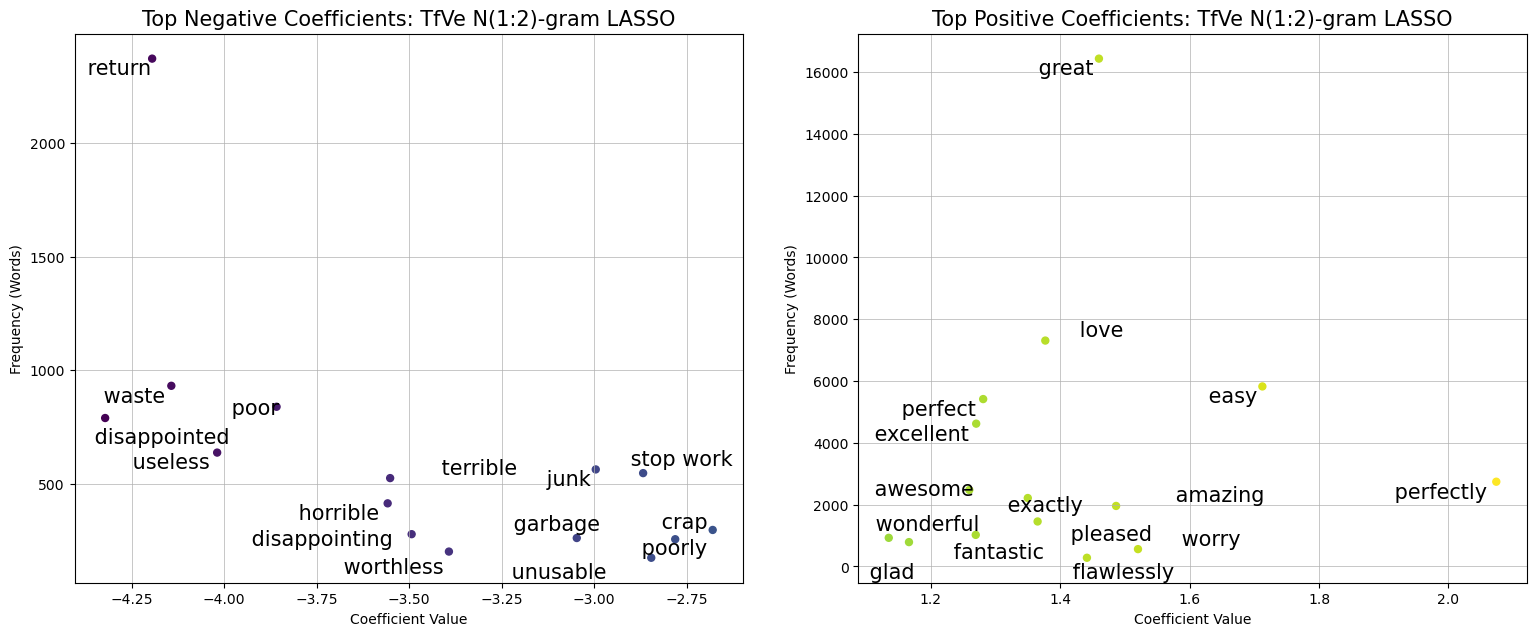

In [24]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_tfidf_1_2[:show]), 
                                  min(top_pos_coef_lasso_tfidf_1_2[:show])), 
                         vmax=max(max(top_neg_coef_lasso_tfidf_1_2[:show]), 
                                  max(top_pos_coef_lasso_tfidf_1_2[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_tfidf_1_2[:show], top_neg_features_feq_lasso_tfidf_1_2[:show],
                      c=top_neg_coef_lasso_tfidf_1_2[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: TfVe N(1:2)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_tfidf_1_2[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_tfidf_1_2[i], top_neg_features_feq_lasso_tfidf_1_2[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_tfidf_1_2[:show], top_pos_features_feq_lasso_tfidf_1_2[:show],
                      c=top_pos_coef_lasso_tfidf_1_2[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: TfVe N(1:2)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_tfidf_1_2[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_tfidf_1_2[i], top_pos_features_feq_lasso_tfidf_1_2[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


### Ngram = 1:3

#### CountVectorizer Ngram = 1:3

In [25]:
# Lasso CV
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,3), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter=max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['countvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_cove_1_3 = pipeline.predict(X_test)
mse_lasso_cove_1_3 = mean_squared_error(y_test, y_pred_lasso_cove_1_3)
acc_lasso_cove_1_3 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_cove_1_3))

print(f'Mean Squared Error: {mse_lasso_cove_1_3}')
print(f'Classification Accuracy: {acc_lasso_cove_1_3}')
best_alpha_ngram_1_3_CoVe = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_3_CoVe}')

Mean Squared Error: 1.0779298965188995
Classification Accuracy: 0.3895467865601541
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [26]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_CoVe_1_3, sorted_coefficients_lasso_CoVe_1_3 = zip(*sorted_features_coefficients)

top_pos_features_lasso_CoVe_1_3 = []
top_pos_coef_lasso_CoVe_1_3 = []
top_pos_features_feq_lasso_CoVe_1_3 = []

top_neg_features_lasso_CoVe_1_3 = []
top_neg_coef_lasso_CoVe_1_3 = []
top_neg_features_feq_lasso_CoVe_1_3 = []

for index, coef in enumerate(sorted_coefficients_lasso_CoVe_1_3):
    if coef > 0:
        top_pos_features_lasso_CoVe_1_3.append(sorted_features_lasso_CoVe_1_3[index])
        top_pos_features_feq_lasso_CoVe_1_3.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_3[index]]))
        top_pos_coef_lasso_CoVe_1_3.append(coef)
    else:
        top_neg_features_lasso_CoVe_1_3.append(sorted_features_lasso_CoVe_1_3[index])
        top_neg_features_feq_lasso_CoVe_1_3.append(sum(X_train_dfm_df[sorted_features_lasso_CoVe_1_3[index]]))
        top_neg_coef_lasso_CoVe_1_3.append(coef)

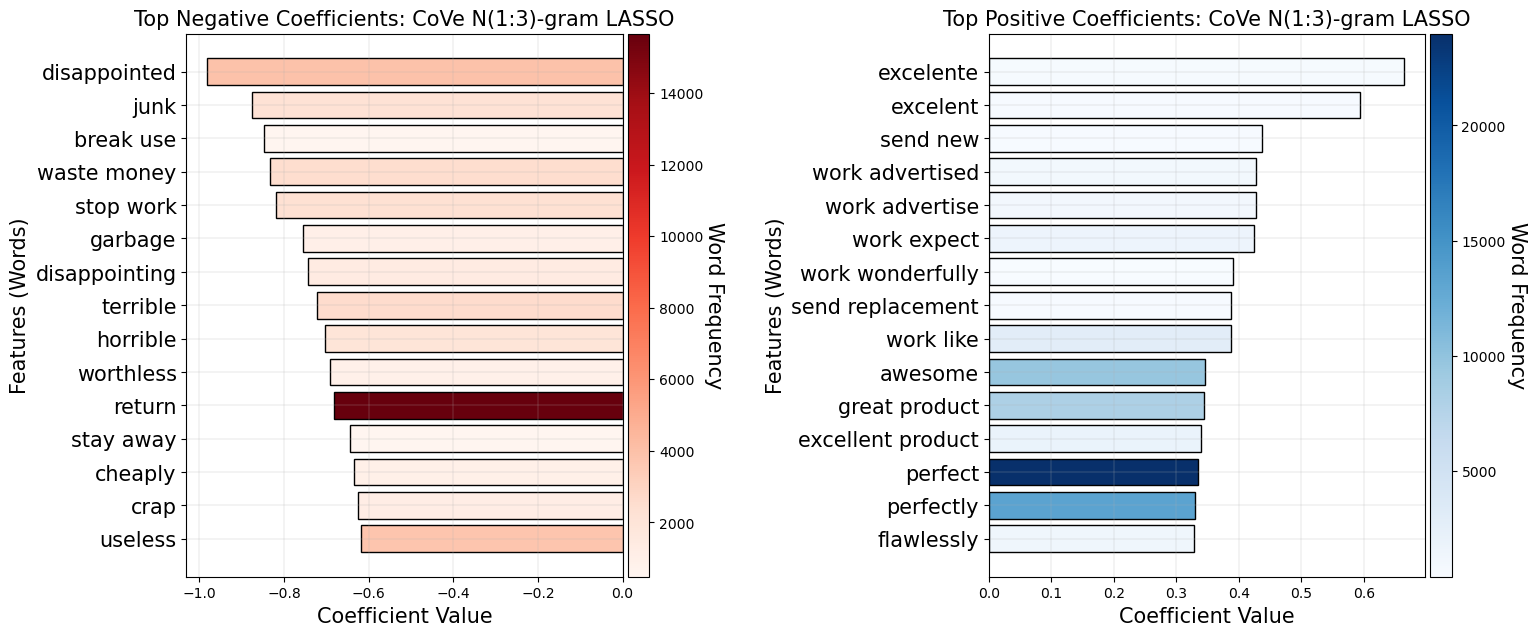

In [27]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_CoVe_1_3[:show]), 
                             vmax=max(top_neg_features_feq_lasso_CoVe_1_3[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_CoVe_1_3[:show]), 
                             vmax=max(top_pos_features_feq_lasso_CoVe_1_3[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_CoVe_1_3[i]))
    ax1.barh(top_neg_features_lasso_CoVe_1_3[i], top_neg_coef_lasso_CoVe_1_3[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: CoVe N(1:3)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_CoVe_1_3[i]))
    ax2.barh(top_pos_features_lasso_CoVe_1_3[i], top_pos_coef_lasso_CoVe_1_3[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: CoVe N(1:3)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


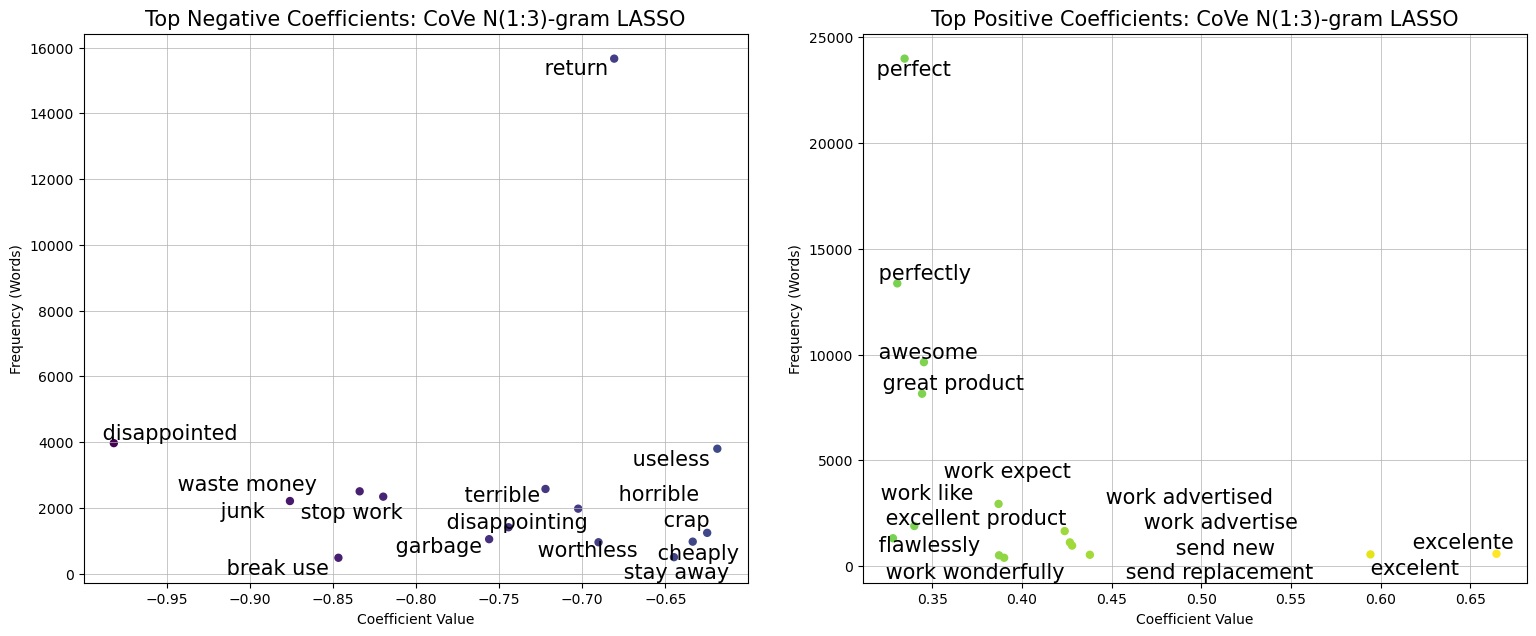

In [28]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_CoVe_1_3[:show]), 
                                  min(top_pos_coef_lasso_CoVe_1_3[:show])), 
                         vmax=max(max(top_neg_coef_lasso_CoVe_1_3[:show]), 
                                  max(top_pos_coef_lasso_CoVe_1_3[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_CoVe_1_3[:show], top_neg_features_feq_lasso_CoVe_1_3[:show],
                      c=top_neg_coef_lasso_CoVe_1_3[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: CoVe N(1:3)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_CoVe_1_3[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_CoVe_1_3[i], top_neg_features_feq_lasso_CoVe_1_3[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_CoVe_1_3[:show], top_pos_features_feq_lasso_CoVe_1_3[:show],
                      c=top_pos_coef_lasso_CoVe_1_3[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: CoVe N(1:3)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_CoVe_1_3[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_CoVe_1_3[i], top_pos_features_feq_lasso_CoVe_1_3[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


#### TfidfVectorizer Ngram = 1:3

In [29]:
# Lasso CV 
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1,3), max_features=max_features)
lasso_cv = LassoCV(cv=cv, random_state=random_state, alphas=alphas_search_space, max_iter= max_iter, n_jobs=n_jobs)
pipeline = make_pipeline(vectorizer, lasso_cv)

pipeline.fit(X_train, y_train)
vectorizer_step = pipeline.named_steps['tfidfvectorizer']

X_train_dfm = vectorizer_step.transform(X_train)
X_train_dense = X_train_dfm.todense()
feature_names = vectorizer_step.get_feature_names_out()
X_train_dfm_df = pd.DataFrame(X_train_dense, columns=feature_names)

y_pred_lasso_tfidf_1_3 = pipeline.predict(X_test)
mse_lasso_tfidf_1_3 = mean_squared_error(y_test, y_pred_lasso_tfidf_1_3)
acc_lasso_tfidf_1_3 = accuracy_score(y_test, round_and_clip_predictions(y_pred_lasso_tfidf_1_3))

print(f'Mean Squared Error: {mse_lasso_tfidf_1_3}')
print(f'Classification Accuracy : {acc_lasso_tfidf_1_3}')
best_alpha_ngram_1_3_tfidf = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha_ngram_1_3_tfidf}')

Mean Squared Error: 0.8891461519683079
Classification Accuracy : 0.47765244269599777
Best alpha: 0.0001


##### Bar Chart of Coefficients to Word Frequency Per Review 

In [30]:
# coefficients = lasso_cv.coef_
coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features_lasso_tfidf_1_3, sorted_coefficients_lasso_tfidf_1_3 = zip(*sorted_features_coefficients)

top_pos_features_lasso_tfidf_1_3 = []
top_pos_coef_lasso_tfidf_1_3 = []
top_pos_features_feq_lasso_tfidf_1_3 = []

top_neg_features_lasso_tfidf_1_3 = []
top_neg_coef_lasso_tfidf_1_3 = []
top_neg_features_feq_lasso_tfidf_1_3 = []

for index, coef in enumerate(sorted_coefficients_lasso_tfidf_1_3):
    if coef > 0:
        top_pos_features_lasso_tfidf_1_3.append(sorted_features_lasso_tfidf_1_3[index])
        top_pos_features_feq_lasso_tfidf_1_3.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_3[index]]))
        top_pos_coef_lasso_tfidf_1_3.append(coef)
    else:
        top_neg_features_lasso_tfidf_1_3.append(sorted_features_lasso_tfidf_1_3[index])
        top_neg_features_feq_lasso_tfidf_1_3.append(sum(X_train_dfm_df[sorted_features_lasso_tfidf_1_3[index]]))
        top_neg_coef_lasso_tfidf_1_3.append(coef)

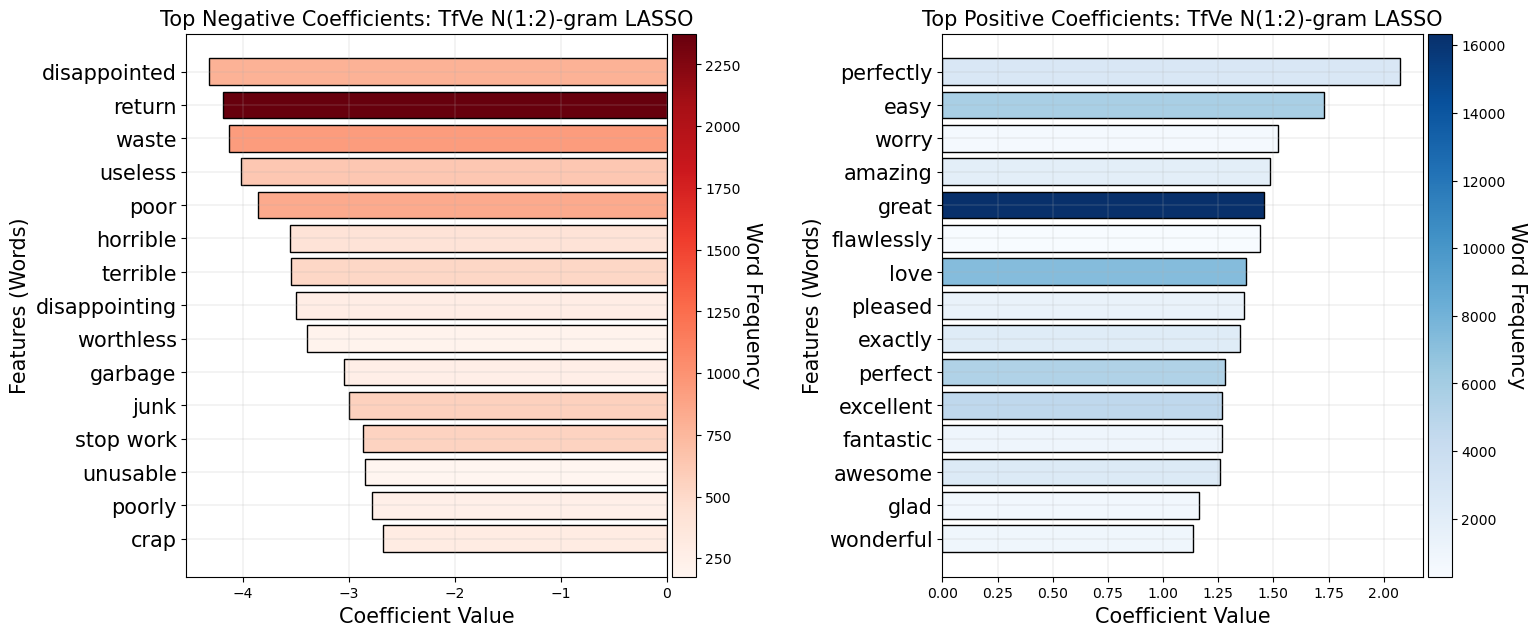

In [31]:
show = 15

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

norm_neg = mcolors.Normalize(vmin=min(top_neg_features_feq_lasso_tfidf_1_3[:show]), 
                             vmax=max(top_neg_features_feq_lasso_tfidf_1_3[:show]))
norm_pos = mcolors.Normalize(vmin=min(top_pos_features_feq_lasso_tfidf_1_3[:show]), 
                             vmax=max(top_pos_features_feq_lasso_tfidf_1_3[:show]))

cmap_neg = plt.cm.Reds
cmap_pos = plt.cm.Blues
alpha_value = 1
features_label_size = 15

for i in range(show):
    color = cmap_neg(norm_neg(top_neg_features_feq_lasso_tfidf_1_3[i]))
    ax1.barh(top_neg_features_lasso_tfidf_1_3[i], top_neg_coef_lasso_tfidf_1_3[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_neg = make_axes_locatable(ax1)
cax_neg = divider_neg.append_axes("right", size="5%", pad=0.05)
cb_neg = plt.colorbar(plt.cm.ScalarMappable(norm=norm_neg, cmap=cmap_neg), cax=cax_neg)
cb_neg.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax1.set_xlabel('Coefficient Value', size=15)
ax1.set_ylabel('Features (Words)', size=15)
ax1.set_title('Top Negative Coefficients: TfVe N(1:2)-gram LASSO', size = 15)
ax1.invert_yaxis()
ax1.grid(True, which='both', linestyle='-', linewidth=0.2)
ax1.tick_params(axis='y', labelsize=features_label_size) 

for i in range(show):
    color = cmap_pos(norm_pos(top_pos_features_feq_lasso_tfidf_1_3[i]))
    ax2.barh(top_pos_features_lasso_tfidf_1_3[i], top_pos_coef_lasso_tfidf_1_3[i], color=color, edgecolor='black', linewidth=1, alpha=alpha_value)

divider_pos = make_axes_locatable(ax2)
cax_pos = divider_pos.append_axes("right", size="5%", pad=0.05)
cb_pos = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pos, cmap=cmap_pos), cax=cax_pos)
cb_pos.set_label('Word Frequency', rotation=270, labelpad=15, size = 15)

ax2.set_xlabel('Coefficient Value', size=15)
ax2.set_ylabel('Features (Words)', size=15)
ax2.set_title('Top Positive Coefficients: TfVe N(1:2)-gram LASSO', size=15)
ax2.invert_yaxis()
ax2.grid(True, which='both', linestyle='-', linewidth=0.2)
ax2.tick_params(axis='y', labelsize=features_label_size) 


plt.tight_layout(pad=3.0)
plt.show()


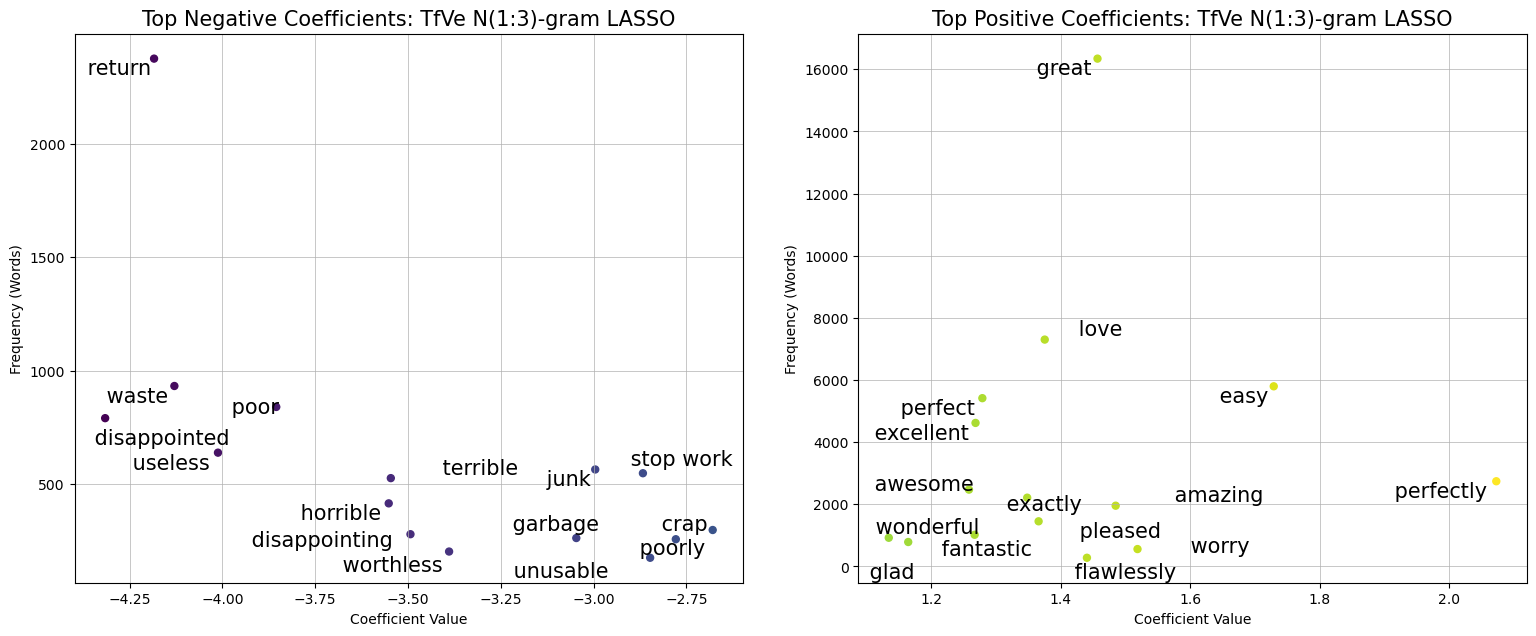

In [38]:
show = 15

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(min(top_neg_coef_lasso_tfidf_1_3[:show]), 
                                  min(top_pos_coef_lasso_tfidf_1_3[:show])), 
                         vmax=max(max(top_neg_coef_lasso_tfidf_1_3[:show]), 
                                  max(top_pos_coef_lasso_tfidf_1_3[:show])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Store text objects for adjustText
texts1 = []
texts2 = []

# Negative Coefficients Scatter Plot
scatter = ax1.scatter(top_neg_coef_lasso_tfidf_1_3[:show], top_neg_features_feq_lasso_tfidf_1_3[:show],
                      c=top_neg_coef_lasso_tfidf_1_3[:show], cmap=cmap, norm=norm, s = 25)
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency (Words)')
ax1.set_title('Top Negative Coefficients: TfVe N(1:3)-gram LASSO', size=15)
ax1.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_neg_features_lasso_tfidf_1_3[:show]):
    texts1.append(ax1.text(top_neg_coef_lasso_tfidf_1_3[i], top_neg_features_feq_lasso_tfidf_1_3[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Positive Coefficients Scatter Plot
scatter = ax2.scatter(top_pos_coef_lasso_tfidf_1_3[:show], top_pos_features_feq_lasso_tfidf_1_3[:show],
                      c=top_pos_coef_lasso_tfidf_1_3[:show], cmap=cmap, norm=norm, s = 25)
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency (Words)')
ax2.set_title('Top Positive Coefficients: TfVe N(1:3)-gram LASSO', size=15)
ax2.grid(True, which='both', linestyle='-', linewidth=0.5)

# Adding labels to the scatter points
for i, label in enumerate(top_pos_features_lasso_tfidf_1_3[:show]):
    texts2.append(ax2.text(top_pos_coef_lasso_tfidf_1_3[i], top_pos_features_feq_lasso_tfidf_1_3[i], ' '+label,
             verticalalignment='center', fontsize=15))

# Apply adjust_text to improve label placement
adjust_text(texts1, ax=ax1, )
adjust_text(texts2, ax=ax2,)

plt.tight_layout(pad=3.0)
plt.show()


## XGBRegressor

In [35]:
# define hyperparameter search space
search_spaces_xgbr = {
    "xgbregressor__n_estimators": Integer(100, 1000),
    "xgbregressor__max_depth": Integer(3, 20),
    "xgbregressor__learning_rate": Real(0.01, 0.2, "log-uniform"),
    "xgbregressor__min_child_weight": Integer(1, 20), 
    "xgbregressor__colsample_bytree": Real(0.5, 1.0),
}

### XGBRegressor CountVectorizer N-gram = 1:1

In [36]:
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1), max_features=max_features)
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror", eval_metric="rmse", random_state=random_state, n_jobs=n_jobs
)
pipeline = make_pipeline(vectorizer, xgb_regressor)

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces_xgbr,
    n_iter=16,
    random_state=random_state,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=n_jobs,
)
np.int = int # prevent error caused by bssearch with newer version of np 

bayes_search.fit(X_train, y_train)

print(f"Best parameters: {bayes_search.best_params_}")
best_score = -bayes_search.best_score_
print(f"Best MSE score: {best_score}")

y_pred_xgb_cove_1_1 = bayes_search.predict(X_test)
mse_xgb_cove_1_1 = mean_squared_error(y_test, y_pred_xgb_cove_1_1)
print(f"Mean Squared Error: {mse_xgb_cove_1_1}")
acc_xgb_cove_1_1 = accuracy_score(y_test, round_and_clip_predictions(y_pred_xgb_cove_1_1))
print(f"Classification Accuracy: {acc_xgb_cove_1_1}")


Best parameters: OrderedDict([('xgbregressor__colsample_bytree', 1.0), ('xgbregressor__learning_rate', 0.08827794666773045), ('xgbregressor__max_depth', 14), ('xgbregressor__min_child_weight', 20), ('xgbregressor__n_estimators', 859)])
Best MSE score: 0.8230775896160223
Mean Squared Error: 0.8092131943889707
Classification Accuracy: 0.529211994701136


### XGBRegressor CountVectorizer N-gram = 1:2

In [39]:
vectorizer = CountVectorizer(min_df=1, ngram_range=(1,2), max_features=max_features)
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror", eval_metric="rmse", random_state=random_state, n_jobs=n_jobs
)
pipeline = make_pipeline(vectorizer, xgb_regressor)

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_spaces_xgbr,
    n_iter=16,
    random_state=random_state,
    cv=cv,
    scoring="neg_mean_squared_error",
    n_jobs=n_jobs,
)
np.int = int # prevent error caused by bssearch with newer version of np 

bayes_search.fit(X_train, y_train)

print(f"Best parameters: {bayes_search.best_params_}")
best_score = -bayes_search.best_score_
print(f"Best MSE score: {best_score}")

y_pred_xgb_cove_1_2 = bayes_search.predict(X_test)
mse_xgb_cove_1_2 = mean_squared_error(y_test, y_pred_xgb_cove_1_2)
print(f"Mean Squared Error: {mse_xgb_cove_1_2}")
acc_xgb_cove_1_2 = accuracy_score(y_test, round_and_clip_predictions(y_pred_xgb_cove_1_2))
print(f"Classification Accuracy: {acc_xgb_cove_1_2}")


Best parameters: OrderedDict([('xgbregressor__colsample_bytree', 1.0), ('xgbregressor__learning_rate', 0.08822048773032239), ('xgbregressor__max_depth', 14), ('xgbregressor__min_child_weight', 20), ('xgbregressor__n_estimators', 845)])
Best MSE score: 0.8200794375853543
Mean Squared Error: 0.8069712122558182
Classification Accuracy: 0.5330817711051343


# Performance Evaluation

In [54]:
np.random.seed(random_state)
y_pred_random_guess = np.random.randint(1, 6, size=len(y_test))
mse_random_guess = mean_squared_error(y_test, y_pred_random_guess)
acc_random_guess = accuracy_score(y_test, round_and_clip_predictions(y_pred_random_guess))

In [55]:
model_performance = {
    "Models": [
        "Random Guess",
        "CoVe N(1:1)-gram LASSO",
        "CoVe N(1:2)-gram LASSO",
        "CoVe N(1:3)-gram LASSO",
        "TfVe N(1:1)-gram LASSO",
        "TfVe N(1:2)-gram LASSO",
        "TfVe N(1:3)-gram LASSO",
        "CoVe N(1:1)-gram XGB_Reg",
        "CoVe N(1:2)-gram XGB_Reg",
    ],
    "MSE": [
        mse_random_guess,
        mse_lasso_cove_1_1,
        mse_lasso_cove_1_2,
        mse_lasso_cove_1_3,
        mse_lasso_tfidf_1_1,
        mse_lasso_tfidf_1_2,
        mse_lasso_tfidf_1_3,
        mse_xgb_cove_1_1,
        mse_xgb_cove_1_2,
    ],
    "Accuracy": [
        acc_random_guess,
        acc_lasso_cove_1_1,
        acc_lasso_cove_1_2,
        acc_lasso_cove_1_3,
        acc_lasso_tfidf_1_1,
        acc_lasso_tfidf_1_2,
        acc_lasso_tfidf_1_3,
        acc_xgb_cove_1_1,
        acc_xgb_cove_1_2,
    ],
}

In [56]:
df_model_performance = pd.DataFrame(model_performance)
df_model_performance.to_csv("model_performance.csv")

In [57]:
df_model_performance

,Models,MSE,Accuracy
0,Random Guess,5.049271,0.201550
1,CoVe N(1:1)-gram LASSO,1.108045,0.370824
2,CoVe N(1:2)-gram LASSO,1.077844,0.389788
3,CoVe N(1:3)-gram LASSO,1.077930,0.389547
4,TfVe N(1:1)-gram LASSO,0.908334,0.466966
5,TfVe N(1:2)-gram LASSO,0.888951,0.477652
6,TfVe N(1:3)-gram LASSO,0.889146,0.477652
7,CoVe N(1:1)-gram XGB_Reg,0.809213,0.529212
8,CoVe N(1:2)-gram XGB_Reg,0.806971,0.533082


In [58]:
df_model_performance_index = df_model_performance.set_index('Models')

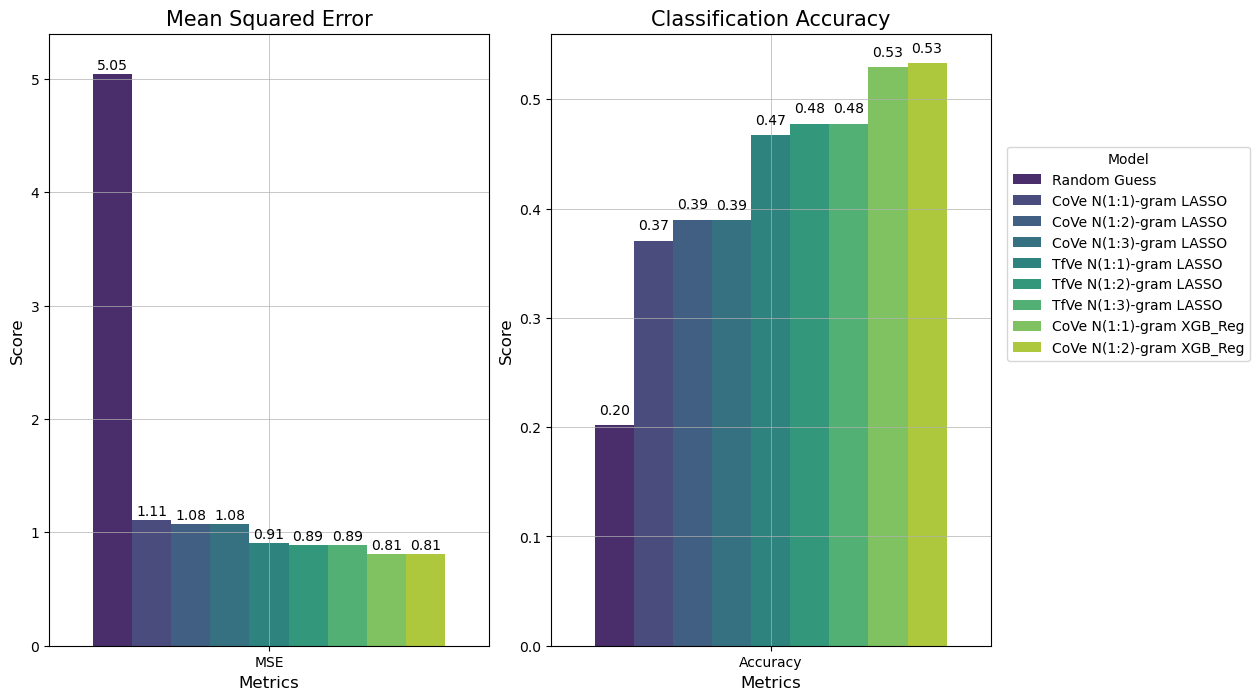

In [59]:
scores_mse = df_model_performance[["Models", "MSE"]].melt(id_vars=["Models"], var_name="Metrics", value_name="Score")

scores_accuracy = df_model_performance[["Models", "Accuracy"]].melt(id_vars=["Models"], var_name="Metrics", value_name="Score")

fig, axes = plt.subplots(1, 2, figsize=(10, 7))  

sns.barplot(x='Metrics', y='Score', hue='Models', data=scores_mse, palette='viridis', ax=axes[0])
axes[0].set_title('Mean Squared Error', size=15)
axes[0].set_xlabel('Metrics', size=12)
axes[0].set_ylabel('Score', size=12)
axes[0].grid(True, which='major', linestyle='-', linewidth=0.5)
axes[0].set_ylim(0, 5.4)

for p in axes[0].patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    axes[0].text(x, height + 0.04, f'{height:.2f}', ha='center', size = 10)


sns.barplot(x='Metrics', y='Score', hue='Models', data=scores_accuracy, palette='viridis', ax=axes[1])
axes[1].set_title('Classification Accuracy', size=15)
axes[1].set_xlabel('Metrics', size=12)
axes[1].set_ylabel('Score', size=12)
axes[1].grid(True, which='major', linestyle='-', linewidth=0.5)
axes[1].set_ylim(0, 0.56)

for p in axes[1].patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    axes[1].text(x, height + 0.01, f'{height:.2f}', ha='center', size = 10)

axes[0].get_legend().remove()
axes[1].get_legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Model', bbox_to_anchor=(1, 0.8), loc='upper left', fontsize=10)


plt.tight_layout(pad=0.7)
plt.show()

# Intertemporal review analysis

### Top Positive Coefficients

CountVectorizer: N-gram = 1

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [10:05<00:00, 37.84s/it]


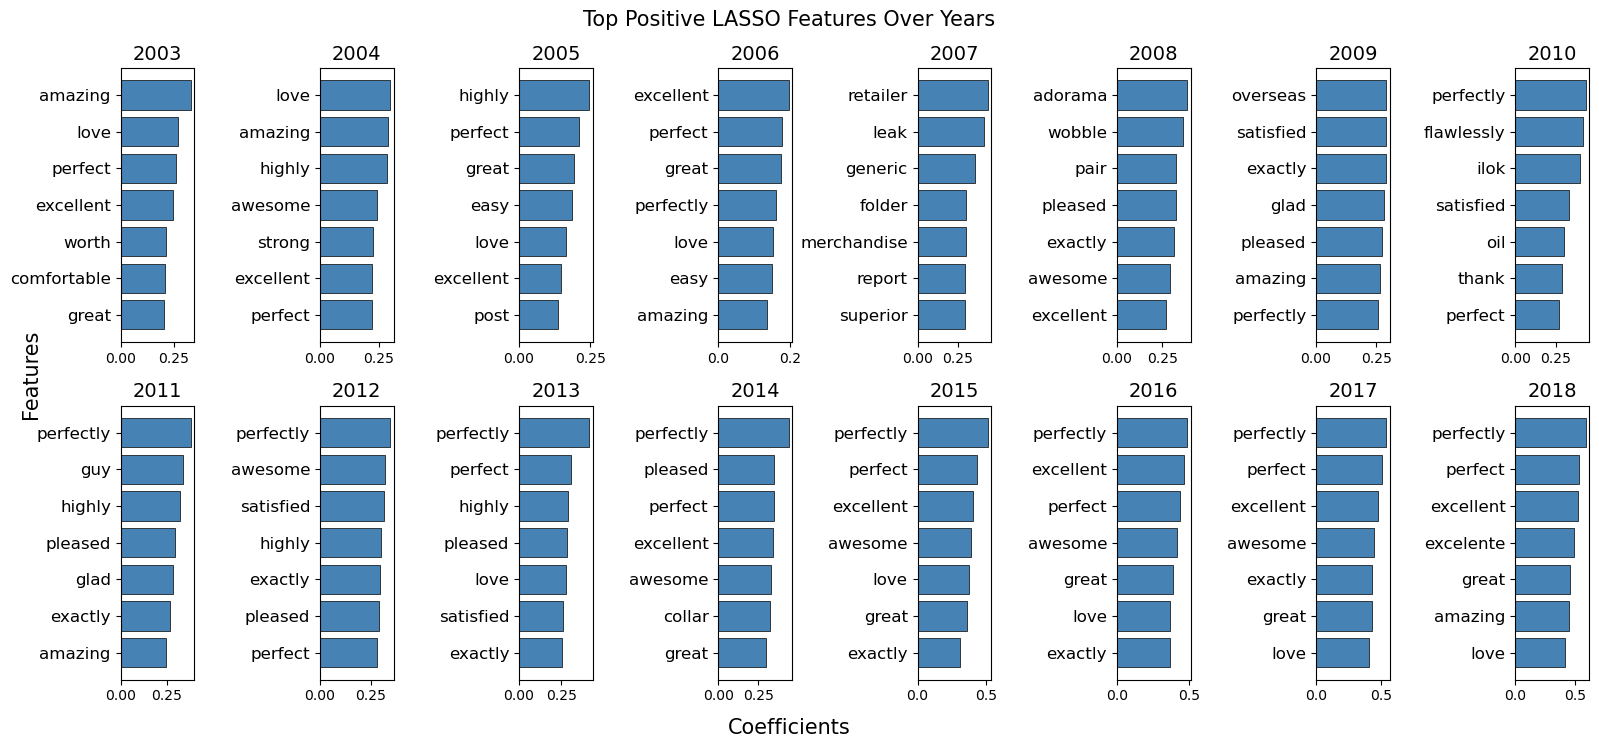

In [46]:
show = 7 # how many top coefficient to show
start_year = 2003
end_year = 2019

fig, axes = plt.subplots(2, 8, figsize=(16, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.2)
axes = axes.ravel() 

for i, year in enumerate(tqdm(range(start_year, end_year))):
    df_year = df_review_subset[df_review_subset["Year"] == year]

    if not df_year.empty:
    
        vectorizer = CountVectorizer(min_df=1, ngram_range=(1, 1), max_features=max_features)
        lasso_cv = LassoCV(cv=3, random_state=random_state, alphas=[0.001, 0.01], max_iter=2500) # 0.001, 0.01, 0.1, 1, 100
        pipeline = make_pipeline(vectorizer, lasso_cv) # lasso_cv
        pipeline.fit(df_year["reviewText"], df_year["overall"])

        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_ # lasso_cv
        feature_names = pipeline.named_steps['countvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] > 0, features_coefficients)  # Filter only positive coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1], reverse=True)
        # Get the top positive features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        ax = axes[i]
        ax.barh(top_features, top_coefficients, color = "steelblue" , edgecolor='black', linewidth=0.5)
        ax.set_title(f'{year}',fontsize=14)
        ax.set_yticks(range(len(top_features)))  # Fix: Set the y-ticks
        ax.set_yticklabels(top_features, fontsize=12)  # Fix: Set the y-tick labels
        ax.invert_yaxis()  

    else:
        axes[i].axis('off')  

fig.suptitle('Top Positive LASSO Features Over Years', fontsize=15, y=1.02)
fig.supxlabel('Coefficients', ha='center', fontsize=15, y = -0.02)
fig.supylabel('Features', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(pad=0.02, h_pad=1.2)
plt.show()


TfidfVectorizer: N-gram = 1

100%|██████████| 16/16 [00:56<00:00,  3.51s/it]


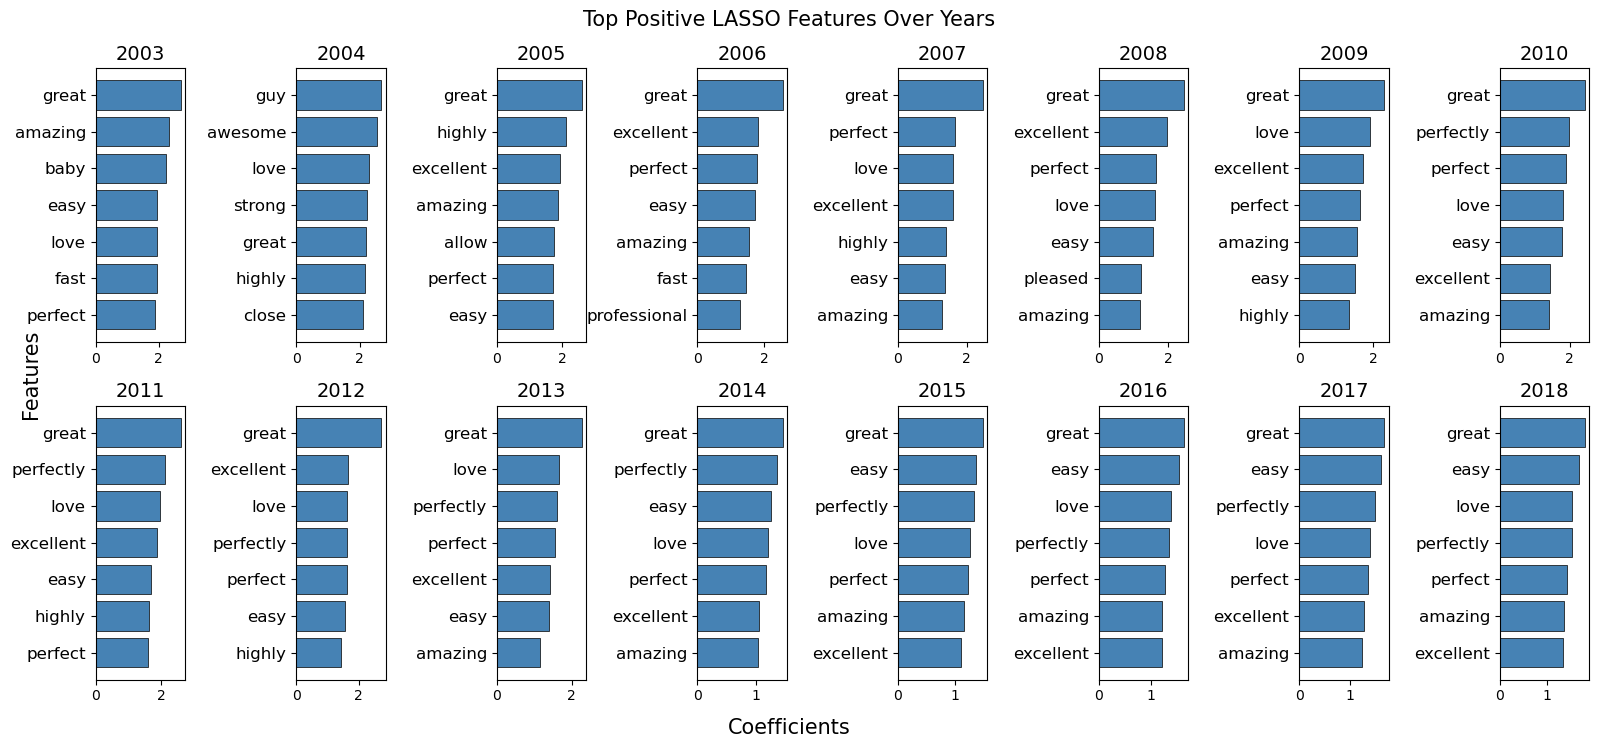

In [47]:
show = 7 # how many top coefficient to show
start_year = 2003
end_year = 2019

fig, axes = plt.subplots(2, 8, figsize=(16, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.2)
axes = axes.ravel() 

for i, year in enumerate(tqdm(range(start_year, end_year))):
    df_year = df_review_subset[df_review_subset["Year"] == year]

    if not df_year.empty:
        
        vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1), max_features=max_features)
        lasso_cv = LassoCV(cv=3, random_state=random_state, alphas=[0.001, 0.01], max_iter=2500) 

        pipeline = make_pipeline(vectorizer, lasso_cv) # lasso_cv
        pipeline.fit(df_year["reviewText"], df_year["overall"])

        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_ # lasso_cv
        feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] > 0, features_coefficients)  # Filter only positive coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1], reverse=True)
        # Get the top positive features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        ax = axes[i]
        ax.barh(top_features, top_coefficients, color = "steelblue" , edgecolor='black', linewidth=0.5)
        ax.set_title(f'{year}',fontsize=14)
        ax.set_yticks(range(len(top_features)))  # Fix: Set the y-ticks
        ax.set_yticklabels(top_features, fontsize=12)  # Fix: Set the y-tick labels
        ax.invert_yaxis()  

    else:
        axes[i].axis('off')  

fig.suptitle('Top Positive LASSO Features Over Years', fontsize=15, y=1.02)
fig.supxlabel('Coefficients', ha='center', fontsize=15, y = -0.02)
fig.supylabel('Features', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(pad=0.02, h_pad=1.2)
plt.show()


### Top Negative Coefficients

CountVectorizer: N-gram = 1

100%|██████████| 16/16 [09:22<00:00, 35.16s/it]


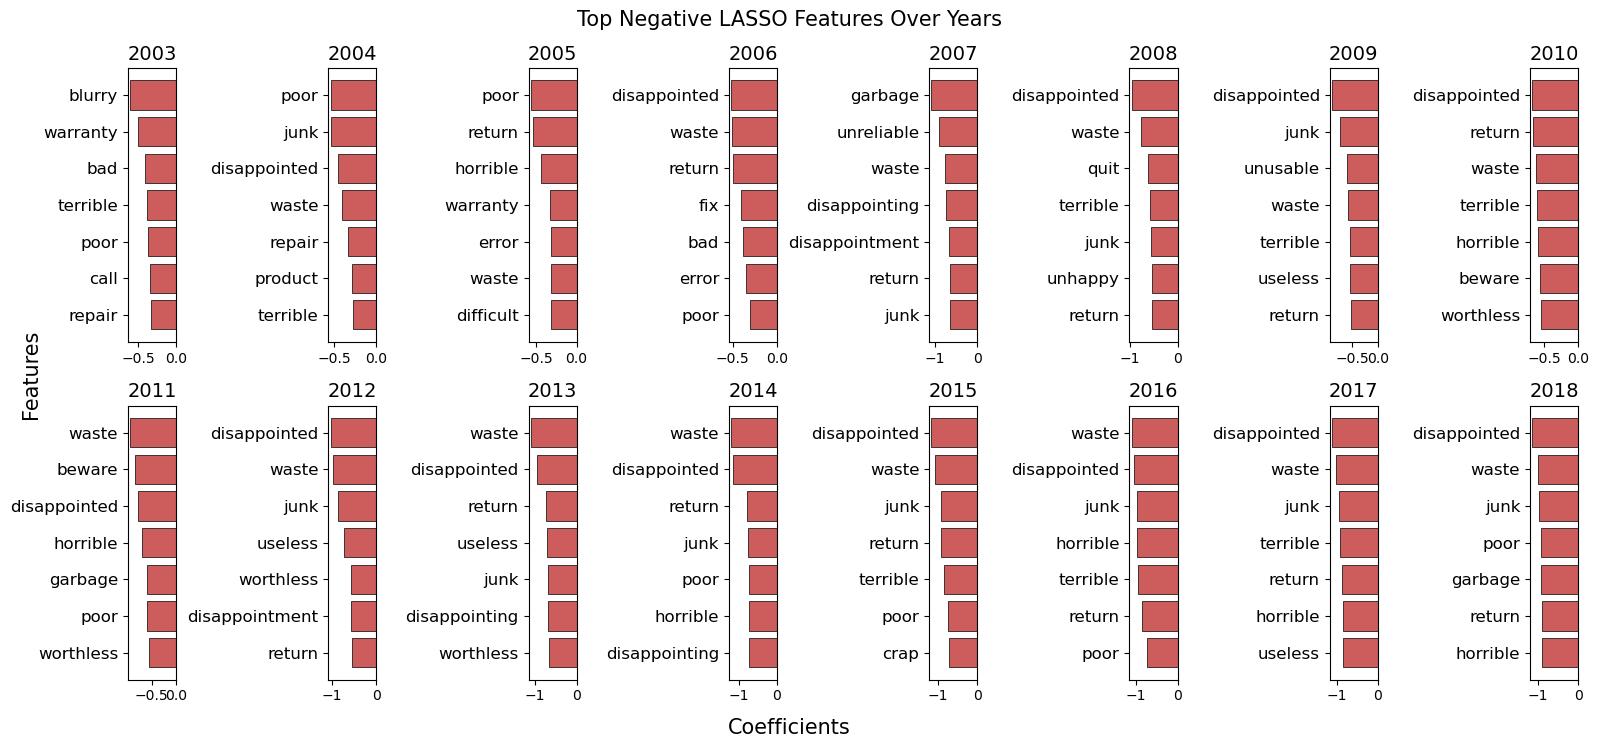

In [48]:
show = 7 # how many top coefficient to show
start_year = 2003
end_year = 2019

fig, axes = plt.subplots(2, 8, figsize=(16, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.2)
axes = axes.ravel() 

for i, year in enumerate(tqdm(range(start_year, end_year))):
    df_year = df_review_subset[df_review_subset["Year"] == year]

    if not df_year.empty:
    
        vectorizer = CountVectorizer(min_df=1, ngram_range=(1, 1), max_features=max_features)
        lasso_cv = LassoCV(cv=3, random_state=random_state, alphas=[0.001, 0.01], max_iter=2500)
        pipeline = make_pipeline(vectorizer, lasso_cv) # lasso_cv
        pipeline.fit(df_year["reviewText"], df_year["overall"])

        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_ # lasso_cv
        feature_names = pipeline.named_steps['countvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] < 0, features_coefficients)  # Filter only Negative coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1])
        # Get the top Negative features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        ax = axes[i]
        ax.barh(top_features, top_coefficients, color = "indianred" , edgecolor='black', linewidth=0.5)
        ax.set_title(f'{year}',fontsize=14)
        ax.set_yticks(range(len(top_features)))  # Fix: Set the y-ticks
        ax.set_yticklabels(top_features, fontsize=12)  # Fix: Set the y-tick labels
        ax.invert_yaxis()  

    else:
        axes[i].axis('off')  

fig.suptitle('Top Negative LASSO Features Over Years', fontsize=15, y=1.02)
fig.supxlabel('Coefficients', ha='center', fontsize=15, y = -0.02)
fig.supylabel('Features', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(pad=0.02, h_pad=1.2)
plt.show()


TfidfVectorizer: N-gram = 1

100%|██████████| 16/16 [00:36<00:00,  2.29s/it]


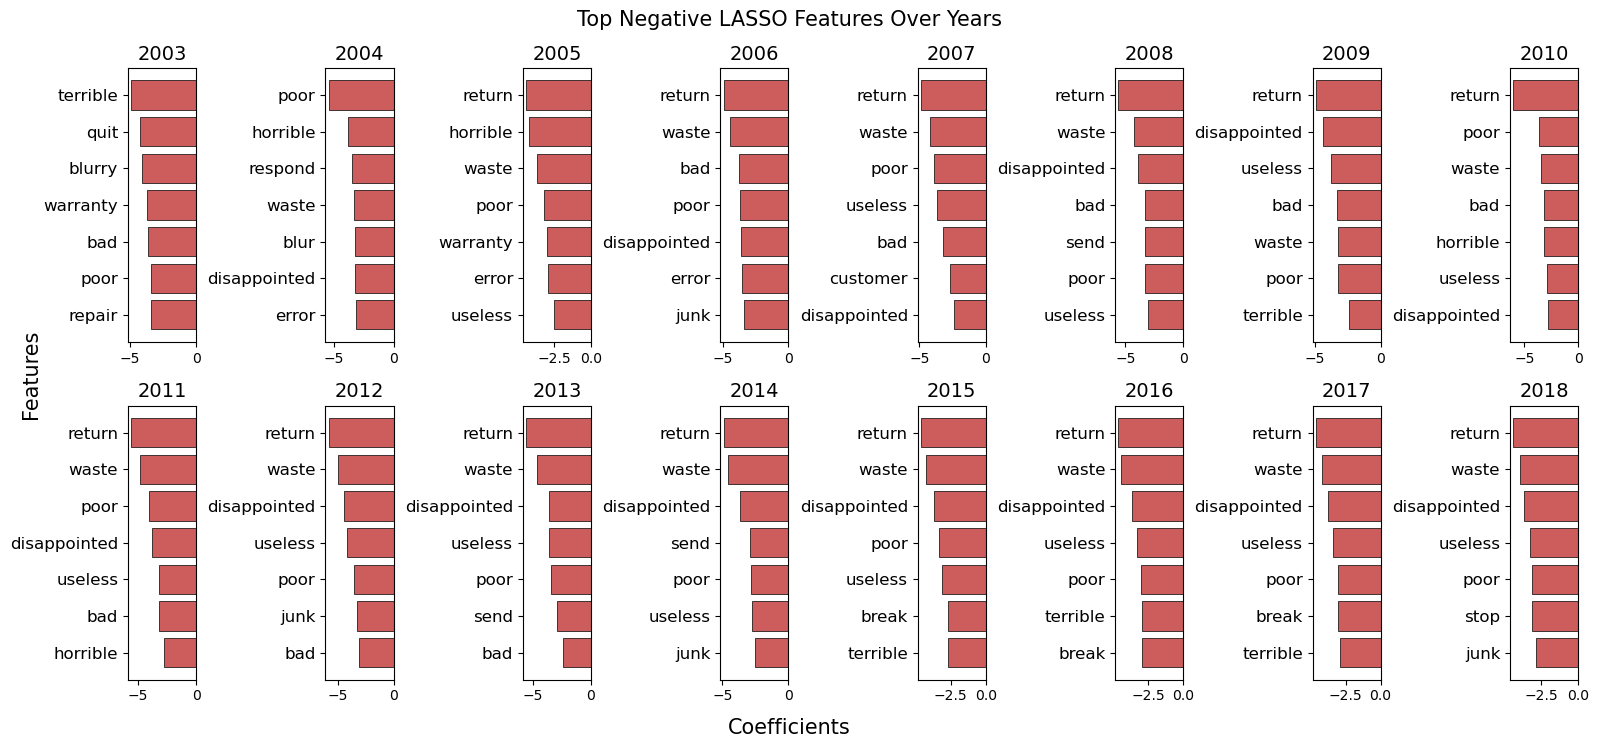

In [49]:
show = 7 # how many top coefficient to show
start_year = 2003
end_year = 2019

fig, axes = plt.subplots(2, 8, figsize=(16, 7))
plt.subplots_adjust(wspace=0.5, hspace=0.2)
axes = axes.ravel() 

for i, year in enumerate(tqdm(range(start_year, end_year))):
    df_year = df_review_subset[df_review_subset["Year"] == year]

    if not df_year.empty:
        
        vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1), max_features=max_features)
        lasso_cv = LassoCV(cv=3, random_state=random_state, alphas=[0.001, 0.01], max_iter=2500) 

        pipeline = make_pipeline(vectorizer, lasso_cv) # lasso_cv
        pipeline.fit(df_year["reviewText"], df_year["overall"])

        # Get the coefficients and feature names
        coefficients = pipeline.named_steps['lassocv'].coef_ # lasso_cv
        feature_names = pipeline.named_steps['tfidfvectorizer'].get_feature_names_out()
        features_coefficients = zip(feature_names, coefficients)
        filtered_features_coefficients = filter(lambda x: x[1] < 0, features_coefficients)  # Filter only negative coefficients
        sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: x[1])
        # Get the top Negative features and their coefficients
        top_features, top_coefficients = zip(*sorted_features_coefficients[:show])

        ax = axes[i]
        ax.barh(top_features, top_coefficients, color = "indianred" , edgecolor='black', linewidth=0.5)
        ax.set_title(f'{year}',fontsize=14)
        ax.set_yticks(range(len(top_features)))  # Fix: Set the y-ticks
        ax.set_yticklabels(top_features, fontsize=12)  # Fix: Set the y-tick labels
        ax.invert_yaxis()  

    else:
        axes[i].axis('off')  

fig.suptitle('Top Negative LASSO Features Over Years', fontsize=15, y=1.02)
fig.supxlabel('Coefficients', ha='center', fontsize=15, y = -0.02)
fig.supylabel('Features', va='center', rotation='vertical', fontsize=15)
plt.tight_layout(pad=0.02, h_pad=1.2)
plt.show()
